# 5 モデルの評価と改良

In [1]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 合成データセットの生成
X,y=make_blobs(random_state=0)
# dataトラベルを訓練セットとテストセットに分割
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)
# モデルのインスタンスを生成し、訓練データで学習
logreg=LogisticRegression().fit(X_train,y_train)
# テストセットでモデルを評価
print("Test set score: {:.2f}".format(logreg.score(X_test,y_test)))

Test set score: 0.88


* データを訓練セットとテストセットに分割するのは、新しく見たことのないデータに対する汎化性能を計測するため
* 交差検証（cross-validation）はより頑健な汎化性能評価手法
* クラス分類や回帰性能を評価する手法についても、scoreメソッドのデフォルトのR^2よりも良い方法を議論する
* 教師あり学習モデルに対して、汎化性能が最大になるように効率的にパラメータを調整するグリッドサーチについて学ぶ

## 5.2 交差検証
* 交差検証（cross-validation）は汎化性能を評価する統計的手法で、ただ訓練セットとテストセットに分割する方法と比べて、より安定で徹底した手法
* 最もよく用いられる交差検証手法はk分割交差検証（k-fold cross-validation）
* kはユーザーが定める数で、多くの場合は5から10程度
* k=5の場合、まずデータを5つの（おおよそ）同じサイズに分割する（これを分割（fold）と呼ぶ）
* 一連のモデルを訓練する
* 最初のモデルは最初の分割をテストセットとして使い、残りの分割を訓練セットとして使う
* 次のモデルは分割2をテストセットとし、分割1,3,4,5を訓練セットとして使う
* この過程を分割3,4,5に対しても繰り返す
* それぞれの訓練セットとデータセットへの分割結果（split）に対して精度を計算する
* 多くの場合、データの最初の1/5を分割1、2つ目の1/5を分割2に、というように先頭から分割していく

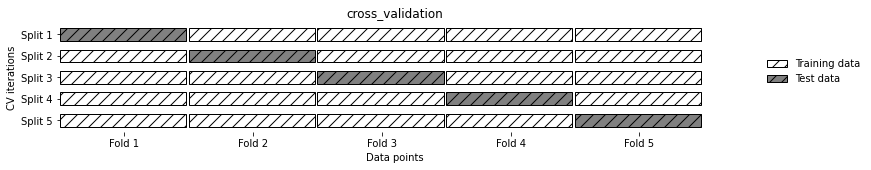

In [2]:
import mglearn
mglearn.plots.plot_cross_validation()

### 5.1.1 scikit-learnでの交差検証
* 交差検証はscikit-learnではmodel_selectionモジュールのcross_val_score関数として実装されている

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

iris=load_iris()
logreg=LogisticRegression(max_iter=10000)

scores=cross_val_score(logreg,iris.data,iris.target)    # デフォルトの分割数k=5
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96666667 1.         0.93333333 0.96666667 1.        ]


* 交差検証の精度をまとめるには、一般に平均値を用いる

In [5]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.97


### 5.1.2 交差検証の利点
* 交差検証を使えば、すべてのデータが正確に1度だけテストに用いられるため、モデルはデータセットのすべてのサンプルに対して良い汎化性能を示さなければ、交差検証スコアとその平均を高くすることができない
* データを多数に分割すると、モデルの訓練データセットに対する敏感さを知ることができる（モデルが最悪の場合と最良の場合でどの程度の性能を示すかがわかる）
* データを単純に分割する場合と比較して、データをより効率的に使え、データが多ければ多いほどモデルが正確になる
* 最大の問題点は計算コスト（k個のモデルを訓練するため、単純な分割の場合に比べておよそk倍遅くなる）

### 5.1.3 層化k分割交差検証と他の戦略
* データセットをk個に分割する際に、データセットの先頭から1/kを取る方法は、いつもうまくいくとは限らない

In [6]:
from sklearn.datasets import load_iris
iris=load_iris()
print("Iris labels:\n{}".format(iris.target))

Iris labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


* 明らかに最初の1/3はクラス0、次の1/3はクラス1、最後の1/3はクラス2になっている
* このような場合に3分割交差検証にかけても、精度は0になってしまう
* 単純なk分割交差検証ではうまくいかないので、クラス分類器に関しては、scikit-learnはこの方法を用いず、層化k分割交差検証（stratified k-fold cross-validation）を用いる
* 層化交差検証では、各分割内でのクラスの比率が全体の比率と同じになるように分割する

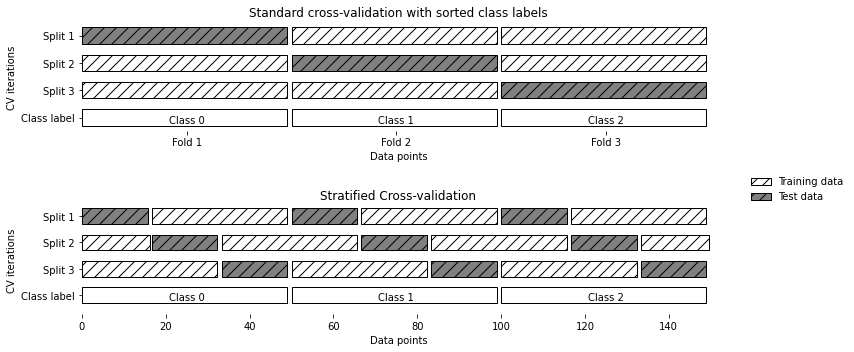

In [8]:
mglearn.plots.plot_stratified_cross_validation()

* 一般に、クラス分類機を評価するには、単純なk分割交差検証ではなく層化k分割交差検証を使ったほうが良い
* 回帰に関しては、scikit-learnは標準的なk分割交差検証をデフォルトで用いる（個々の分割が回帰ターゲットの分布を反映するようにすることもできるが、そのようにすることはあまりない）

#### 5.1.3.1 交差検証のより詳細な制御
* scikit-learnでは、cross_val_scoreのcvパラメータに交差検証分割器（cross-validation splitter）を与えることで、データ分割の方法をより詳細に制御することができる
* 殆どの場合は、回帰にはk分割交差検証、クラス分類には層化k分割交差検証というデフォルトの動作でうまくいく
* 別の人が行った結果を再現するために、クラス分類にk分割交差検証を用いる場合などは、以下の方法で行う

In [9]:
from sklearn.model_selection import KFold
kfold=KFold(n_splits=5)

print("Cross-validation scores:\n{}".format(cross_val_score(logreg,iris.data,iris.target,cv=kfold)))

Cross-validation scores:
[1.         1.         0.86666667 0.93333333 0.83333333]


* 3分割の層化されていない交差検証をirisデータセットに使うとひどいことになる

In [10]:
kfold=KFold(n_splits=3)
print("Cross-validation scores:\n{}".format(cross_val_score(logreg,iris.data,iris.target,cv=kfold)))

Cross-validation scores:
[0. 0. 0.]


* 何も学習できていない
* 層化して分割する代わりに、データをシャッフルしてサンプルがラベル順に並ばないようにする方法もある（KFoldのshuffleパラメータをTrueにする。random_stateも同時に設定したほうが良い）

In [11]:
kfold=KFold(n_splits=3,shuffle=True,random_state=0)
print("Cross-validation scores:\n{}".format(cross_val_score(logreg,iris.data,iris.target,cv=kfold)))

Cross-validation scores:
[0.98 0.96 0.96]


#### 5.1.3.2 1つ抜き交差検証
* k分割交差検証の個々の分割が1サンプルしかないものと考え、毎回テストセット中の1サンプルだけをテストセットとして検証する
* 大規模データでは非常に時間がかかるが、小さいデータセットに関しては、よりよい推定が可能になる

In [12]:
from sklearn.model_selection import LeaveOneOut
loo=LeaveOneOut()
scores=cross_val_score(logreg,iris.data,iris.target,cv=loo)
print("Number of iterations: ",len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

Number of iterations:  150
Mean accuracy: 0.97


#### 5.1.3.3 シャッフル分割交差検証
* シャッフル分割交差検証（shuffle-split cross validation）は非常に柔軟な交差検証手法
* 毎回train_size個の点を選び出して訓練セットとし、test_size個の（訓練セットとは重複しない）点を選び出してテストセットとする
* これをn_iter回繰り返す

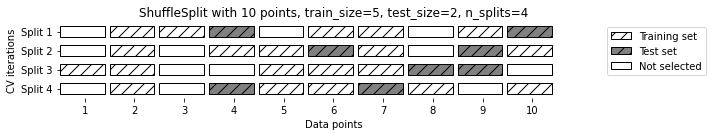

In [13]:
mglearn.plots.plot_shuffle_split()

In [14]:
# データセットの50%を訓練セットに、50%をテストセットにして10回分割を繰り返す例
from sklearn.model_selection import ShuffleSplit
shuffle_split=ShuffleSplit(test_size=.5,train_size=.5,n_splits=10)
scores=cross_val_score(logreg,iris.data,iris.target,cv=shuffle_split)
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.93333333 0.96       0.96       0.92       0.98666667 0.97333333
 0.96       0.98666667 0.96       0.97333333]


* シャッフル交差検証を用いると、訓練セットとテストセットのサイズとは独立に繰り返し回数を制御できる
* train_sizeとtest_sizeの和が1にならないようにすることで、データの一部だけを用いるようにすることができる（サブサンプリングと呼ばれ、データセットが大きい場合に有効）
* ShuffleSplitにも層化バージョンがあり、StaratifiedShuffleSplitという名前がついている（クラス分類ではより信頼できる結果を得られる）

#### 5.1.3.4 グループ付き交差検証
* 顔画像から感情を認識するシステムを作る場合、クラス分類機の目的はデータセットに属していない人の感情を正確に予測すること
* クラス分類機の性能を評価するのに層化交差検証を用いた場合、同じ人が訓練セットにもテストセットにも含まれてしまう
* 訓練セットに含まれる人の感情を予測するのは、全く見たことのない人の感情を予測するより大幅に簡単になってしまう
* 新しい顔に対する汎化性能を正確に評価するには訓練セットとテストセットに含まれる人が重ならないようにしなければならない
* これを実現するためには、GroupFoldを用いる
* この関数は引数にgroupsという配列を取り、この配列には画像に写っている人を指定する（クラスラベルとは違う.この場合のクラスラベルは「嬉しい」など）
* 医療アプリケーションなどでは、同じ患者から得られた複数のサンプルを用いて、新しい患者に対する予測を行うのが目的
* 発話認識では、同じ話者による録音がデータセットに複数含まれている場合に。新しい話者の発話を認識することが目的


In [16]:
from sklearn.model_selection import GroupKFold
# 合成データセットを生成
X,y=make_blobs(n_samples=12,random_state=0)
# 最初の3サンプルが同じグループに次の4サンプルが同じグループに、、というようにする
groups=[0,0,0,1,1,1,1,2,2,3,3,3]
scores=cross_val_score(logreg,X,y,groups=groups,cv=GroupKFold(n_splits=3))
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.75       0.6        0.66666667]


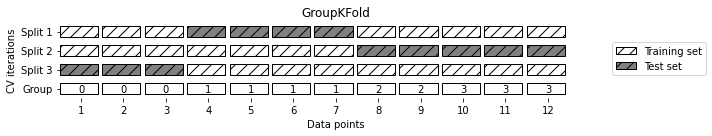

In [17]:
mglearn.plots.plot_group_kfold()

* 個々のグループは完全に訓練セットに入っているか、完全にテストセットに入っているかのどちらかになる

## 5.2 グリッドサーチ
* グリッドサーチは（grid search）、基本的にはパラメータのすべての組み合わせを試してみる方法

### 5.2.1 単純なグリッドサーチ
* RBFを用いたカーネル法を用いたSVMを使う場合、重要なパラメータとしてカーネルのバンド幅を表すgammaと、正則化パラメータCの2つがある
* 単純なグリッドサーチは、2つのパラメータに対するただのforループで実装することができる

In [18]:
# ナイーブなグリッドサーチの実装
from sklearn.svm import SVC 
X_train,X_test,y_train,y_test=train_test_split(iris.data,iris.target,random_state=0)
print("Size of trianing set: {}    size of test set: {}".format(X_train.shape[0],X_test.shape[0]))

best_score=0

for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in [0.001,0.01,0.1,1,10,100]:
        # それぞれのパラメータの組み合わせに対してSVCを訓練
        svm=SVC(gamma=gamma,C=C)
        svm.fit(X_train,y_train)
        # SVCをテストセットで評価
        score=svm.score(X_test,y_test)
        # 良いスコアだったらスコアとパラメータを保存
        if score>best_score:
            best_score=score
            best_parameters={'C':C,'gamma':gamma}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of trianing set: 112    size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


### 5.2.2 パラメータの過剰適合の危険性と検証セット
* テストデータをパラメータのチューニングに使ってしまったので、このテストデータをモデルの精度を評価するのには使えない
* この問題を解決する方法の1つは、データをもう一度分割し、3つのセットにする方法がある

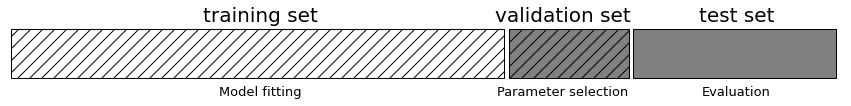

In [19]:
mglearn.plots.plot_threefold_split()

* 検証セットを用いて最良のパラメータを選択したら、そのパラメータを用いてモデルを再構築する
* この際に、訓練データだけでなく検証データも用いることで、可能な限りデータを有効に利用してモデルを構築することができる

In [20]:
from sklearn.svm import SVC 
# データを訓練＋検証セットとテストセットに分割する
X_trainval,X_test,y_trainval,y_test=train_test_split(iris.data,iris.target,random_state=0)
# 訓練＋検証セットを訓練セットと検証セットに分割する
X_train,X_valid,y_train,y_valid=train_test_split(X_trainval,y_trainval,random_state=1)
print("Size of trianing set: {}    size of validation set: {}    size of test set: {}".format(X_train.shape[0],X_valid.shape[0],X_test.shape[0]))

best_score=0

for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in [0.001,0.01,0.1,1,10,100]:
        # それぞれのパラメータの組み合わせに対してSVCを訓練
        svm=SVC(gamma=gamma,C=C)
        svm.fit(X_train,y_train)
        # SVCを検証セットで評価
        score=svm.score(X_valid,y_valid)
        # 良いスコアだったらスコアとパラメータを保存
        if score>best_score:
            best_score=score
            best_parameters={'C':C,'gamma':gamma}

# 訓練セットと検証セットを用いてモデルを再構築し、テストセットで評価
svm=SVC(**best_parameters)
svm.fit(X_trainval,y_trainval)
test_score=svm.score(X_test,y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ",best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of trianing set: 84    size of validation set: 28    size of test set: 38
Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


* 新しいデータに対する精度として主張できるのは、97%ではなく92%ということになる
* テストセットは分離しておき、最後の評価にだけ用いるようにしなければならない
* 厳密には、テストセットで2つ以上のモデルで評価して良い方を選ぶだけでも、モデルの精度を楽観的に見積もりすぎることになる

### 5.2.3 交差検証を用いたグリッドサーチ
* データを訓練セットと検証セットとテストセットに分割する方法は有用だが、データの実際の分割され方によって性能が大きく変動する
* 汎化性能をより良く見積もるためには、訓練セットと検証セットの分割を一度だけ行うのではなく、それぞれのパラメータの組み合わせに対して交差検証を行えば良い
* 交差検証を用いたグリッドサーチを交差検証と呼ぶ場合も多い

In [21]:
import numpy as np

best_score=0

for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in [0.001,0.01,0.1,1,10,100]:
        # それぞれのパラメータの組み合わせに対してSVCを訓練
        svm=SVC(gamma=gamma,C=C)
        # 交差検証を行う
        scores=cross_val_score(svm,X_trainval,y_trainval,cv=5)
        # 交差検証精度の平均値を取る
        score=np.mean(scores)
        # 良いスコアだったらスコアとパラメータを保存
        if score>best_score:
            best_score=score
            best_parameters={'C':C,'gamma':gamma}

# 訓練セットと検証セットを用いてモデルを再構築し、テストセットで評価
svm=SVC(**best_parameters)
svm.fit(X_trainval,y_trainval)
test_score=svm.score(X_test,y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ",best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Best score on validation set: 0.97
Best parameters:  {'C': 10, 'gamma': 0.1}
Test set score with best parameters: 0.97


ValueError: The number of FixedLocator locations (21), usually from a call to set_ticks, does not match the number of ticklabels (36).

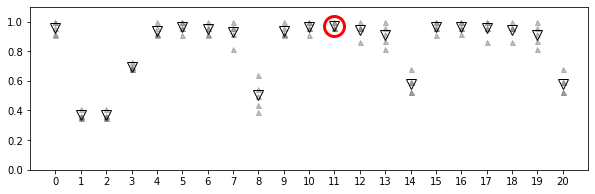

In [22]:
mglearn.plots.plot_cross_val_selection()

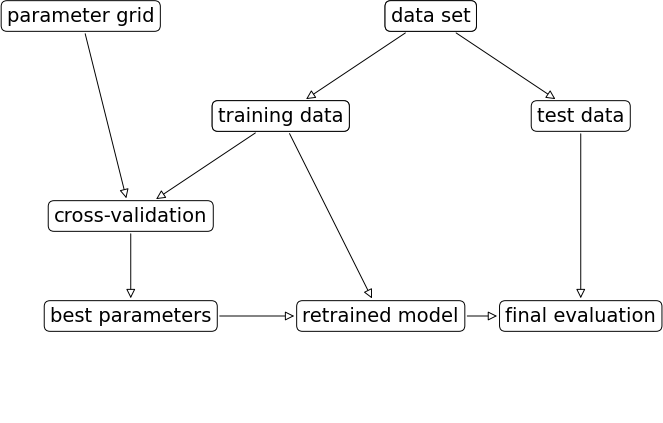

In [23]:
mglearn.plots.plot_grid_search_overview()

* 交差検証を用いたグリッドサーチは非常に一般的にパラメータチューニングに使われるので、scikit-learnではEstimatorの形でこの手法を実装したGridSearchCVクラスを提供している
* GridSearchCVクラスを使うには、まずディクショナリを用いて探索したいパラメータを指定する
* ディクショナリのキーはチューニングしたいパラメータ名で、キーに対応する値には試したい値を与える

In [24]:
param_grid={'C':[0.001,0.01,0.1,1,10,100],'gamma':[0.001,0.01,0.1,1,10,100]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
grid_search=GridSearchCV(SVC(),param_grid,cv=5)

X_train,X_test,y_train,y_test=train_test_split(iris.data,iris.target,random_state=0)

grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

* GridSearchCVオブジェクトのfitメソッドを呼び出すと、最適なパラメータ設定をサーチするだけでなく、交差検証で最も良いスコアだったパラメータを用いて、自動的に訓練セット全体に対して新しいモデルを学習してくれる
* 最適なパラメータの汎化性能を知りたければscoreメソッドをテストセットに対して呼び出せば良い

In [26]:
print("Test set score: {:.2f}".format(grid_search.score(X_test,y_test)))

Test set score: 0.97


* ここで重要なのが、このパラメータを選ぶのにテストセットを使わなかったということ
* 見つけたパラメータはbest_params_属性に、交差検証精度（そのパラメータ設定のさまざまな分割に対する平均精度）はbest_score_属性に格納されている

In [27]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross_validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.1}
Best cross_validation score: 0.97


* 見つけた実際のモデルにアクセスして、係数あるいは特徴量の重要性を見たい場合は、best_estimator_属性を用いてアクセスすることで見ることができる
* grid_searchそのものにも、predictメソッドやscoreメソッドが実装されているので、予測を行ったりするために、best_estimator_属性を用いる必要はない

In [28]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
SVC(C=10, gamma=0.1)


#### 5.2.3.1 交差検証の結果の解析
* 交差検証の結果を可視化すると、モデルの汎化性能がサーチパラメータに依存する様子を理解するのに役立つ
* グリッドサーチは計算量的に高価なので、比較的粗く小さいグリッドから始めるほうが良い
* グリッドサーチの結果はcv_results_属性に格納されている

In [30]:
import pandas as pd 
# DataFrameへ変換
results=pd.DataFrame(grid_search.cv_results_)
# 最初の5行を表示
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001078,0.000338,0.000634,0.000258,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
1,0.001455,0.000328,0.000783,0.000308,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
2,0.003608,0.003480,0.001025,0.000649,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
3,0.001225,0.000206,0.000596,0.000127,0.001,1,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
4,0.000959,0.000161,0.000704,0.000537,0.001,10,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22


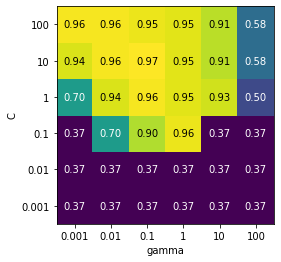

In [31]:
scores=np.array(results.mean_test_score).reshape(6,6)

# 平均交差検証スコアのプロット
mglearn.tools.heatmap(scores,xlabel='gamma',xticklabels=param_grid['gamma'],ylabel='C',yticklabels=param_grid['C'],cmap="viridis")

* SVCはパラメータの設定に敏感であることがわかる
* 良い性能を得るためにはパラメータの設定が非常に重要（SVCではCとgammaの双方のパラメータが重要）
* パラメータのレンジは十分に大きくしなければならない（それぞれのパラメータの最良値がプロットの端にならないようにすべき）

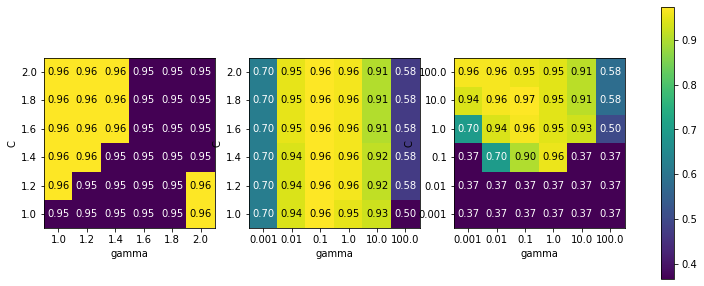

In [33]:
import matplotlib.pyplot as plt

fig,axes=plt.subplots(1,3,figsize=(13,5))
param_grid_linear={'C':np.linspace(1,2,6),'gamma':np.linspace(1,2,6)}
param_grid_one_log={'C':np.linspace(1,2,6),'gamma':np.logspace(-3,2,6)}
param_grid_range={'C':np.logspace(-3,2,6),'gamma':np.logspace(-3,2,6)}

for param_grid,ax in zip([param_grid_linear,param_grid_one_log,param_grid_range],axes):
    grid_search=GridSearchCV(SVC(),param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    scores=grid_search.cv_results_['mean_test_score'].reshape(6,6)

    # 平均交差検証精度をプロット
    scores_image=mglearn.tools.heatmap(scores,xlabel='gamma',ylabel='C',xticklabels=param_grid['gamma'],yticklabels=param_grid['C'],cmap="viridis",ax=ax)

plt.colorbar(scores_image,ax=axes.tolist())

* ↑サーチグリッドが不適切な場合のヒートマップによる可視化
* パラメータグリッドを交差検証スコアを用いてチューニングすることはなんの問題もないが、最後のテストセットを使ってパラメータレンジを探索してはいけない

#### 5.2.3.2 グリッドではないサーチ空間
* GridSearchCVはparam_gridとしてディクショナリのリストを受け付ける用に作られている
* リスト中の個々のリストが独立したグリッドに展開される

In [34]:
param_grid=[
    {'kernel':['rbf'],'C':[0.001,0.01,0.1,1,10,100],'gamma':[0.001,0.01,0.1,1,10,100]},
    {'kernel':['linear'],'C':[0.001,0.01,0.1,1,10,100]}
]
print("List of grid:\n{}".format(param_grid))

List of grid:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In [36]:
grid_search=GridSearchCV(SVC(),param_grid,cv=5)
grid_search.fit(X_train,y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.97


In [37]:
results=pd.DataFrame(grid_search.cv_results_)
display(results.T)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.001455,0.001545,0.001463,0.001254,0.001246,0.00146,0.001859,0.001159,0.00091,0.001024,...,0.000907,0.000934,0.001873,0.001269,0.000987,0.001359,0.00384,0.000887,0.001095,0.001097
std_fit_time,0.001295,0.000559,0.000343,0.000368,0.000304,0.000662,0.002176,0.000613,0.000233,0.000276,...,0.000417,0.000368,0.001941,0.000402,0.00022,0.000916,0.006012,0.000241,0.000402,0.000434
mean_score_time,0.000616,0.000763,0.000943,0.001292,0.000775,0.000704,0.000501,0.000445,0.000479,0.000603,...,0.000967,0.000332,0.000564,0.000587,0.000479,0.002282,0.000379,0.00113,0.002139,0.00048
std_score_time,0.00041,0.000032,0.000365,0.000891,0.000236,0.000239,0.000127,0.000032,0.000118,0.000159,...,0.001046,0.000032,0.000189,0.000174,0.0001,0.004005,0.000096,0.00143,0.003445,0.000112
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1.0,0.956522,0.869565,0.521739,0.347826,0.869565,1.0,1.0,1.0,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,0.956522,0.956522,0.913043,0.521739,0.347826,0.869565,0.913043,0.956522,1.0,0.956522


#### 5.2.3.3 異なる交差検証手法を用いたグリッドサーチ
* GridSearchCVはcross-val_scoreと同様に、デフォルトではクラス分類には層化k分割交差検証を、回帰にはk分割交差検証を用いる
* 交差検証の分割器をcvパラメータにわたすことができるので、訓練セットと検証セットとの分割を一度だけ行いたい（データセットが非常に大きい、計算に時間がかかるなど）場合は、ShuffleSplitもしくはStratifiedShuffleSplitを用いて、n_iter=1にすると良い

#### 5.2.3.4 ネストした交差検証
* 訓練セットとテストセットの分割が一度だけだと、その一回の分割に結果が依存してしまうため、不安定になる可能性がある
* もとのデータを訓練セットとテストセットに一度だけ分けるのではなく、交差検証で何度も分割することを考える（ネストした交差検証）
* ネストした交差検証では、外側にループを設け、そこでデータを訓練セットとテストセットに分割し、それぞれの分割に対してグリッドサーチを実行する
* ここで、外側ループのそれぞれの分割に対して最良のパラメータの組み合わせは異なるかもしれない
* それぞれの分割に対して、最良のセッティングでテストセットを評価した結果が報告される
* この手続きの結果はスコアのリストであり、このモデルのグリッドから見つけた最適なパラメータによる汎化性能を表す
* 新しいデータに対して利用できるモデルを与えるわけではないので、ネストした交差検証は未来のデータに適用するための予測モデルを探すために用いられることはほとんどないが、あるモデルのあるデータセットに対する性能の評価には有用

In [38]:
scores=cross_val_score(GridSearchCV(SVC(),param_grid,cv=5),iris.data,iris.target,cv=5)
print("Cross-validation scores: ",scores)
print("Mean cross-validation score: ",scores.mean())

Cross-validation scores:  [0.96666667 1.         0.9        0.96666667 1.        ]
Mean cross-validation score:  0.9666666666666668


* このネストした交差検証の結果は「SVCはirisデータセットに対して交差検証精度の平均で98%を達成することができる」ことを表している（それ以上でもそれ以下でもない）
* ネストした交差検証は計算量的に非常に高価
* 内側と外側のループに対して任意の交差検証手法の組み合わせを用いることができる

In [43]:
# ネストした交差検証をforループで表したコード
def nested_cv(X,y,inner_cv,outer_cv,Classifier,parameter_grid):
    outer_scores=[]
    # 外側の交差検証による個々の分割に対するループ
    # (splitメソッドはインデックスを返す)
    for training_samples,test_samples in outer_cv.split(X,y):
        # 内側の交差検証を用いて最良のパラメータ設定を見つける
        best_params={}
        best_score=-np.inf
        # 個々のパラメータ設定に対してループ
        for parameters in parameter_grid:
            # 内側の分割に対するスコアを格納
            cv_scores=[]
            # 内側の交差検証のループ
            for inner_train,inner_test in inner_cv.split(X[training_samples],y[training_samples]):
                # 与えられたパラメータと訓練セットでクラス分類器を訓練
                clf=Classifier(**parameters)
                clf.fit(X[inner_train],y[inner_train])
                # 内側のテストセットを評価
                score=clf.score(X[inner_test],y[inner_test])
                cv_scores.append(score)
            # 内部の分割に対するスコアの平均を算出
            mean_score=np.mean(cv_scores)
            if mean_score>best_score:
                # これまでのものよりも良ければパラメータを記憶
                best_score=mean_score
                best_params=parameters
        # 最良のパラメータセットと外側の訓練セットを用いてクラス分類機を構築
        clf=Classifier(**best_params)
        clf.fit(X[training_samples],y[training_samples])
        # 評価する
        outer_scores.append(clf.score(X[test_samples],y[test_samples]))
    return np.array(outer_scores)

In [44]:
from sklearn.model_selection import ParameterGrid,StratifiedKFold
scores=nested_cv(iris.data,iris.target,StratifiedKFold(5),StratifiedKFold(5),SVC,ParameterGrid(param_grid))
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96666667 1.         0.96666667 0.96666667 1.        ]


#### 5.2.3.5 交差検証とグリッドサーチの並列化
* たくさんのパラメータの組み合わせに対して大規模データセットを用いてグリッドサーチを行うには膨大な計算量が必要になるが、この操作は単純並列（embarrassingly parallel）でもある
* つまり、特定の交差検証分割に対する特定のパラメータ設定でのモデル構築は、他のパラメータ設定や分割に対して完全に独立に実行できるため、CPUコアやクラスタを用いての並列化ができる
* GridSearchCVとcross_val_scoreでは、パラメータn_jobsに利用したいコア数を設定することで、複数のコアを利用することができる（n_jobs=-1で利用できるすべてのコアを使用する）
* ただし、scikit-learnではネストした並列実行はサポートされていない（モデルでn_jobsオプションを使っていたらGridSearchCVでは使えない）
* データセットやモデルが非常に大きい場合、たくさんのコアを使おうとするとメモリを使いすぎる場合があるため、大規模なモデルを並列に構築する場合はメモリを監視する必要がある
* グリッドサーチと交差検証をクラスタの複数マシンを用いて並列化することも可能だが、scikit-learnには実装されていない
* IPythonの並列化フレームワークを使って並列グリッドサーチを実装することはできるが、パラメータセットに対してforループを書く必要がある
* spark-sklearn(https://github.com/databricks/spark-sklearn)パッケージを用いれば、グリッドサーチをSparkクラスタ上で実行することができる

## 5.3 評価基準とスコア